# Human Intervention:

- Human intervention in agentic AI workflows means allowing a human to guide, approve, or correct the AI’s actions.
- It is needed to prevent mistakes, reduce harmful decisions, and handle situations where the AI is uncertain or the task is high-risk.
- Humans can also add judgment, ethics, and domain knowledge that AI may lack.
- Human intervention can be done in three main ways:
    - Human-in-the-loop – human approves or give permission or give inputs or edits the AI’s decision before it continues. It is done using tool call
    - Human-on-the-loop – the AI runs on its own, but a human monitors and can step in if needed.
    - Human-out-of-the-loop (with fallback) – the AI works independently, but escalates to a human when it cannot proceed safely.

## Building Human in Loop Agent to use the paid websearch tool (Without Exception Handling)

### Setup

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["LANGCHAIN_PROJECT"]="AgentiAICourse_01"
os.environ["LANGCHAIN_TRACING_V2"]="true"

from langchain_openai import ChatOpenAI

TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
from langchain_tavily import TavilySearch

#search_tool.invoke("what is GDP of US in 2024", max_results=5)
# Search Agent
llm = ChatOpenAI(model="gpt-4o")


/Users/chandra/Courses/DataScience/NLP/AgenticAI/agenticaienv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/chandra/Courses/DataScience/NLP/AgenticAI/agenticaienv/lib/python3.11/site-packages/pydantic/_internal/_fields.py:198: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  warnings.warn(
/Users/chandra/Courses/DataScience/NLP/AgenticAI/agenticaienv/lib/python3.11/site-packages/pydantic/_internal/_fields.py:198: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  warnings.warn(


In [ ]:

from typing import Annotated, List
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from typing_extensions import TypedDict
from langgraph.prebuilt import create_react_agent
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command

In [15]:
from langchain_core.tools import tool

@tool
def multiplication(a: float,b:float)->float:
    """ Multiplication of two numbers"""
    return a*b
    

@tool
def web_search(query: str)-> str:
    """Tavily Web Search for a given query"""
    tavily_tool=TavilySearch(tavily_api_key=TAVILY_API_KEY)
    result= tavily_tool.invoke(query)
    return f"Result from query {query} is: \n{result}"

web_search.invoke({"query": "What is the price of iPhone 17 Pro Max ?"})


"Result from query What is the price of iPhone 17 Pro Max ? is: \n{'query': 'What is the price of iPhone 17 Pro Max ?', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.att.com/buy/phones/apple-iphone-17-pro-max.html', 'title': 'Buy New iPhone 17 Pro Max | Price, Colors and Plans | AT&T', 'content': 'Pricing option ... $33.34 per month. $33.34/mo. Full retail price. $1199.99. $1199.99. Trade in and save. Get monthly bill credits toward your new', 'score': 0.9995695, 'raw_content': None}, {'url': 'https://prices.appleinsider.com/iphone-17-pro-max', 'title': 'iPhone 17 Pro Max Sale Prices', 'content': '# iPhone 17 Pro Max Sale Prices. | 256GB iPhone 17 Pro Max in Silver | $1,199 | From $2.78/mo | n/a | n/a | $0 |. | 256GB iPhone 17 Pro Max in Cosmic Orange | $1,199 | From $2.78/mo | n/a | n/a | $0 |. | 256GB iPhone 17 Pro Max in Deep Blue | $1,199 | From $2.78/mo | n/a | n/a | $0 |. | 512GB iPhone 17 Pro Max in Silver | $1,399 | From $8.34/mo | 

In [16]:
tools=[multiplication,web_search]
llm_with_tool= llm.bind_tools(tools)

tool_mapping={tool.name:tool for tool in tools}

In [20]:
from typing import TypedDict,Sequence, Annotated,List
import operator
from langchain_core.messages import BaseMessage

class MessagesState(TypedDict):
    """State message"""
    messages: Annotated[Sequence[BaseMessage],operator.add]


def llm_node(state:MessagesState):
    response=llm_with_tool.invoke(state["messages"][-1])
    return {"messages":[response]}

def router_node(state:MessagesState):
    tool_calls=state["messages"][-1].tool_calls
    if len(tool_calls)>0:
        return "tool"
    else:
        return "end"
    
def tool_node(state: MessagesState):
    tool_details= state["messages"][-1].tool_calls

    if tool_details is None:
        return Exception("No tool call found in the last message")
    
    print(f"Selected tool: {tool_details[0]['name']}")

    if tool_details[0]["name"]=="web_search":
        response = input(prompt=f"Do you want to proceed with paid search ? [yes/no]")
        if response.lower()=="no":
            print("web search discarded by the user")
            raise Exception("web search discarded by the user")
        
    response=tool_mapping[tool_details[0]["name"]].invoke(tool_details[0]["args"])
    return {"messages":[response]}
            

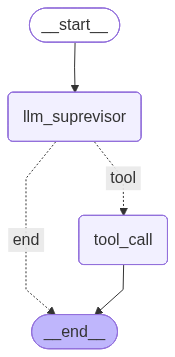

In [21]:
from langgraph.graph import StateGraph, START, END


graph=StateGraph(MessagesState)
graph.add_node("llm_suprevisor", llm_node)
graph.add_node("tool_call",tool_node)
graph.add_conditional_edges("llm_suprevisor",router_node,{"tool":"tool_call","end":END})
graph.add_edge("tool_call",END)
graph.set_entry_point("llm_suprevisor")
app=graph.compile()
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [22]:
app.invoke({"messages":["What is the current gdp of the india?"]})

Selected tool: web_search


{'messages': ['What is the current gdp of the india?',
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bPesLMhY1JwU7wumJKvjiFrL', 'function': {'arguments': '{"query":"current GDP of India 2023"}', 'name': 'web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 79, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_e819e3438b', 'id': 'chatcmpl-CmmfEyYXCMqNLNC4sEuuBd626qEUe', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ba74d20e-6a91-45e0-9231-4a74d83fde11-0', tool_calls=[{'name': 'web_search', 'args': {'query': 'current GDP of India 2023'}, 'id': 'call_bPesLMhY1JwU7wumJKvjiFrL', 'type': 'tool_call'}], usage_metadata={

In [23]:
app.invoke({"messages":["What is the 4 * 8?"]})

Selected tool: multiplication


{'messages': ['What is the 4 * 8?',
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bFnz8ZoCUWfOSP7v6kT9JYUn', 'function': {'arguments': '{"a":4,"b":8}', 'name': 'multiplication'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 78, 'total_tokens': 97, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_e819e3438b', 'id': 'chatcmpl-CmmfhpUuVgNQvvHtESbX6jLeSscZc', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--eeeaa808-6e24-420c-95ab-3ffb10eaa496-0', tool_calls=[{'name': 'multiplication', 'args': {'a': 4, 'b': 8}, 'id': 'call_bFnz8ZoCUWfOSP7v6kT9JYUn', 'type': 'tool_call'}], usage_metadata={'input_tokens': 78, 'output_tokens': 19, 'total_tokens': 

In [24]:
app.invoke({"messages":["What is the current gdp of the india?"]})

Selected tool: web_search
web search discarded by the user


Exception: web search discarded by the user

### LangGraph Build Human In Loop
- use interrupt parameter and here we are setting it before calling the tools because we want to ask user whether to use the paid tool or not

In [25]:
from langgraph.prebuilt import ToolNode, tools_condition
tool_node=ToolNode(tools)

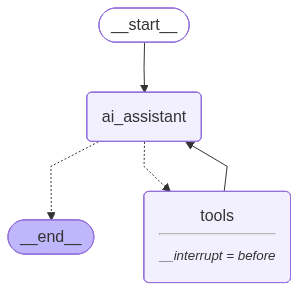

In [27]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()
graph_builder=StateGraph(MessagesState)
graph_builder.add_node("ai_assistant", llm_node)
graph_builder.add_node("tools", tool_node)
graph_builder.add_edge(START,"ai_assistant")
graph_builder.add_conditional_edges("ai_assistant",
                                    tools_condition,
                                    )
graph_builder.add_edge("tools", "ai_assistant")
app=graph_builder.compile(checkpointer=memory,interrupt_before=["tools"])
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [28]:
config={"configurable":{"thread_id":"1"}}
from langchain_core.messages import HumanMessage
response=app.invoke({"messages":[HumanMessage("What is the current gdp of the china?")]},config=config)

ValueError: Invalid input type <class 'langchain_core.messages.human.HumanMessage'>. Must be a PromptValue, str, or list of BaseMessages.

In [ ]:
#snapshot=app2.get_state(config)